In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import ast

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score,precision_score

# Movie Recommendation Project - Through Correlations With Liked Films And The Year Watching

In this project we will try to predict which movie should be your next movie, what makes our algorithm more interesting is that it takes into consideration the year you're are watching the movie as movie genres popularity is varying depending on the year.

At first, as a POC we will build a recommendation system that is content based filtering, the system will offer generalized recommendations to every user based on the popularity, the genres and the movie's runtime. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

Later on, we will try to extend the algorithm with adding demographic filtering based models. Giving a user a more specific recommendation based on his rating on other movies and taking into consideration the popularity of a certian genres in the year he is watching.
 
Some interesting analysis we are hoping to come a cross while working on this:

- Genre popularity based on the year, we can tell by that if there was a major event that may cause a specific genre to be more popular
- What is the perfect runtime? is there such a thing?
- What year is the best year to release movie?
- Are people consistently watching the same genre films? e.g. People who watch war, crime and thriller films likely to watch only those genres


_Because of low-quality data on old movies, we will **not** ignore movies that were released after the year of watching parameter._

# Lets load our data

In [43]:
imdb_df = pd.read_csv('https://www.dropbox.com/s/e6qbgjyrlseh2is/imdb.csv?dl=1',error_bad_lines=False,warn_bad_lines=False)
meta_mov_df = pd.read_csv('https://www.dropbox.com/s/j9vxjw3g1s7wqsg/movies_metadata.csv?dl=1')
rating_df = pd.read_csv('https://www.dropbox.com/s/tizyp5zreilielv/ratings.csv?dl=1')
movies_df = pd.read_csv('https://www.dropbox.com/s/oy74gpybw74e4hm/movies.csv?dl=1')
rating_small_df = pd.read_csv('https://www.dropbox.com/s/526407vecqfcco8/ratings_small.csv?dl=1')

# imdb_df = pd.read_csv('imdb.csv',error_bad_lines=False,warn_bad_lines=False)
# meta_mov_df = pd.read_csv('movies_metadata.csv')
# rating_df = pd.read_csv('ratings.csv')
# movies_df = pd.read_csv('movies.csv')
# rating_small_df = pd.read_csv('ratings_small.csv')

/Users/culturetripisrael/anaconda3/envs/movie-recommendation-notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### IMDb's dataset contains the following features:

- tid - IMDb movie id
- IMDb Rating + Rating Count - Average ratings the movie recieved + the count of votes recieved
- Year - Year of release
- One-hot encoding of the genres of each film

#### MovieLens's dataset has the following features:

- adult - Is it an adult film
- budget - How much money was invested
- genres - Genres the movie classified to
- imdb_id - IMDb's ID
- overview - Description of the movie
- popularity - A numeric quantity specifying the movie popularity
- production_companies - The production house of the movie.
- production_countries - The country in which it was produced.
- release_date - The date of the movie release
- revenue - How much revenue the movie generated worldwide
- runtime - How long is the movie in minutes
- tagline - Movie's tagline
- title - Title of the movie
- vote_average - average ratings the movie recieved.
- vote_count - the count of votes recieved.

##### rating dataset:

- userId - A unique value for each user
- movieId - A unique movie id in MovieLens
- rating - The user rating for that movie
- timestamp - The time the movie was rated

#### Just a peak at our data

In [3]:
imdb_df.head()

,fn,tid,title,wordsInTitle,url,imdbRating,ratingCount,duration,year,type,...,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western
0,titles01/tt0012349,tt0012349,Der Vagabund und das Kind (1921),der vagabund und das kind,http://www.imdb.com/title/tt0012349/,8.4,40550.0,3240.0,1921.0,video.movie,...,0,0,0,0,0,0,0,0,0,0
1,titles01/tt0015864,tt0015864,Goldrausch (1925),goldrausch,http://www.imdb.com/title/tt0015864/,8.3,45319.0,5700.0,1925.0,video.movie,...,0,0,0,0,0,0,0,0,0,0
2,titles01/tt0017136,tt0017136,Metropolis (1927),metropolis,http://www.imdb.com/title/tt0017136/,8.4,81007.0,9180.0,1927.0,video.movie,...,0,0,0,1,0,0,0,0,0,0
3,titles01/tt0017925,tt0017925,Der General (1926),der general,http://www.imdb.com/title/tt0017925/,8.3,37521.0,6420.0,1926.0,video.movie,...,0,0,0,0,0,0,0,0,0,0
4,titles01/tt0021749,tt0021749,Lichter der Großstadt (1931),lichter der gro stadt,http://www.imdb.com/title/tt0021749/,8.7,70057.0,5220.0,1931.0,video.movie,...,0,0,1,0,0,0,0,0,0,0


## Cleaning IMDb dataset

taking a look at anomlies, years where there is low number of movies,
finding the longest sequance of years with movie count higher then 10

our relevant years are bewteen 1922 to 2014


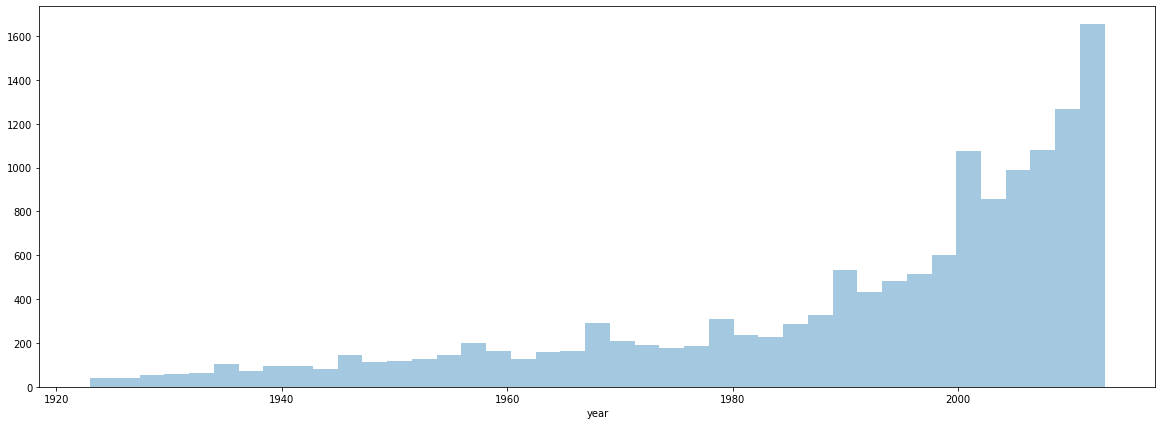

In [4]:
# group by year
groupby_year = imdb_df.groupby('year').size().reset_index(name='count').sort_values(['year'])

# for each year, if it has sufficient number of movies
groupby_year['count'] = groupby_year['count'].apply(lambda x: x < 10)

groupby_year.reset_index(inplace=True)

# search for sequence of years with 10 >= movies
groupby_year = groupby_year.groupby(groupby_year['count'].cumsum()).agg(
    {'year':['count', 'min', 'max']})

groupby_year.columns = groupby_year.columns.droplevel()

# get the longest year sequence in the dataset
years_limit = groupby_year[groupby_year['count']==groupby_year['count'].max()]

print('our relevant years are bewteen {} to {}'.format(
    int(years_limit['min'].values),int(years_limit['max'].values))
)

# clean movies out of limit
imdb_df = imdb_df[(imdb_df['year'] > int(years_limit['min'].values)) & (imdb_df['year'] < int(years_limit['max'].values))]

f, axes = plt.subplots(figsize=(20, 7))

# Get a feeling of number of movies per year > 10
sns.distplot(imdb_df['year'], ax=axes, kde=False)
plt.show()

## Cleaning MovieLens dataset

Data cleaning progress, remove duplicate rows and rows with bad revnue values

In [5]:
sub_sample_size = int(len(rating_df)/30)
rating_df_sample = rating_df.sample(n=sub_sample_size, random_state=42)

#moveis meta data
duplications = len(meta_mov_df['id']) - len(meta_mov_df.drop_duplicates(['id']))
print("<<<=== There are %s unique movies in our Data and (%s) Duplications ===>>>" % (len(meta_mov_df['id'].unique()),duplications))
print("\n")
# After inspections in df we found duplicated rows so we'll drop the to keep unique values
meta_mov_df.drop_duplicates(['id'])

#cleaning bad valued in revnue column
meta_mov_df.dropna(subset=['revenue'],inplace=True)

<<<=== There are 45436 unique movies in our Data and (30) Duplications ===>>>




# Let's start to inspcet our data

#### Rating dataset

<<<=== lets check out the movies rating years ===>>>


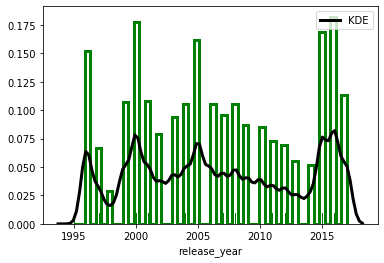

<<<=== checking the ratings means distributions ===>>>


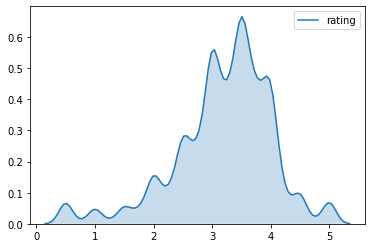

In [6]:
# Let's see at what years the user rated films

# rating_df inspection of rating 
rating_df_sample['date'] = rating_df_sample.apply(lambda x: str(datetime.fromtimestamp(x['timestamp']).strftime('%Y-%m-%d')),axis=1)
rating_df_sample['release_year'] = pd.to_datetime(rating_df_sample['date']).dt.year

# dist of year
print('<<<=== lets check out the movies rating years ===>>>')
sns.distplot(rating_df_sample['release_year'],rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})
plt.show()

print('<<<=== checking the ratings means distributions ===>>>')
ratings_mean = rating_df_sample.groupby(by=['movieId'])['rating'].mean()
sns.kdeplot(ratings_mean,shade=True)
plt.show()

#### Movie metadata dataset

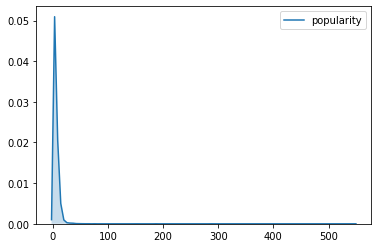

In [7]:
# distabition of the popularity values
meta_mov_df['popularity'] = pd.to_numeric(meta_mov_df['popularity'],errors='coerce')
sns.kdeplot(meta_mov_df['popularity'], shade=True)

As we can see, the popularity rate isn't distributed normally, we will later on check if popularity has any correlation with a movie being recommended 

#### Looking at the vote count and vote average

As shown in the graph below, we can see that the `vote_average` feature, which represents the average ratings that the movie recieved doesn't corresponds with the `vote_count`.
We can see by that there are movies with high vote average but small number of voters, it doesn't necessarily mean that it's better than a movie with a smaller vote average but with high number of voters.

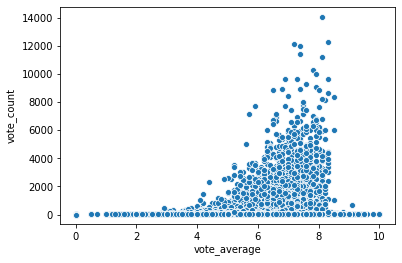

In [8]:
sns.scatterplot(y='vote_count', x='vote_average',data=meta_mov_df[['vote_count','vote_average']])

## Lets create our new film Data Set to try to predict a recommended movies

What do we consider a recommended movie? A movie with weighted rate above avarage. We think  movie will have a higher probability of being liked by the average audience

The model will try to predict if a movie will have an above avarage rate just by the runtime, popularity and the movie's genres.

#### Normalizing our ratings

[based on IMDb's formula](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)

How do you calculate the rank of movies and TV shows on the Top Rated Movies and Top Rated TV Show lists?
The following formula is used to calculate the Top Rated 250 titles. This formula provides a true 'Bayesian estimate', which takes into account the number of votes each title has received, minimum votes required to be on the list, and the mean vote for all titles:

`weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C`

Where:

R = average for the movie (mean) = (rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed in the Top Rated list (currently 25,000)

C = the mean vote across the whole report

Please be aware that the Top Rated Movies Chart only includes theatrical features: shorts, TV movies, miniseries and documentaries are not included in the Top Rated Movies Chart. The Top Rated TV Shows Chart includes TV Series, but not TV episodes or Movies.

In [9]:
def calculate_weighted_rate(row):
    m = meta_mov_df['vote_count'].quantile(0.9)
    c = meta_mov_df['vote_average'].mean()
    v = row['vote_count']
    r = row['vote_average']
    res = (v / (v+m)) * r + (m / (v+m)) * c
    return res

meta_mov_df['weighted_rate'] = meta_mov_df.apply(calculate_weighted_rate,axis=1 )

print(meta_mov_df['weighted_rate'])

0        7.640253
1        6.820293
2        5.940132
3        5.702645
4        5.660700
           ...   
45461    5.608156
45462    5.680449
45463    5.552489
45464    5.618207
45465    5.618207
Name: weighted_rate, Length: 45460, dtype: float64


In [10]:
movie_genre_df = meta_mov_df[['id','imdb_id','title','budget','revenue','genres','runtime','release_date','vote_average',
                              'vote_count','weighted_rate','popularity']]

def get_values_from_genre_json(row, genre):
    movies_many_genres = ast.literal_eval(row['genres'])
    movies_genres = []
    for item in movies_many_genres:
        movies_genres.append(item['name'])
    if genre in movies_genres:
        return 1
    else:
        return 0

# extracting the genres
genres_list = set()
for index, value in movie_genre_df['genres'].iteritems():
    movies_genres = ast.literal_eval(value)
    for item in movies_genres:
        genres_list.add(item['name'])
genres_list = list(genres_list)

# hot-one encoding for the genres
for genre in genres_list:
    movie_genre_df[genre] = movie_genre_df.apply(lambda x: get_values_from_genre_json(x, genre), axis=1)

movie_genre_df = movie_genre_df.drop(columns=['genres', 'id', 'imdb_id', 'title','release_date','revenue','budget'])
movie_genre_df = movie_genre_df[movie_genre_df['popularity'] != 'Beware Of Frost Bites']
movie_genre_df = movie_genre_df[movie_genre_df['runtime'].notna()]

# here we set the recommended film column based on mean
wr_mean = movie_genre_df['weighted_rate'].mean()

# drop the columns that weight rate is based on them
movie_genre_df['recommended'] = movie_genre_df.apply(lambda x: 'True' if x['weighted_rate']>=wr_mean else 'False' ,axis=1)
movie_genre_df.drop(columns=['weighted_rate','vote_average', 'vote_count'],inplace=True)

/Users/culturetripisrael/anaconda3/envs/movie-recommendation-notebook/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/culturetripisrael/anaconda3/envs/movie-recommendation-notebook/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


### Lets fit our model

At first the recommendation prediciton will be based on the runtime, popularity and genres columns.

We will use 3 different models, and we will choose the best one.

In [11]:
Xs = movie_genre_df.drop('recommended',axis=1)
y = movie_genre_df['recommended']
X_train,X_test,y_train,y_test = train_test_split(Xs,y,test_size=0.20,random_state=0)
X_train.shape,X_test.shape

((36162, 22), (9041, 22))

In [12]:
ML_models = {}
model_index = ['LR','RF','NN']
model_sklearn = [LogisticRegression(solver='liblinear',random_state=0),
                 RandomForestClassifier(n_estimators=100,random_state=0),
                 MLPClassifier([100]*5,early_stopping=True,learning_rate='adaptive',random_state=0)]

model_summary = []

for name,model in zip(model_index,model_sklearn):
    ML_models[name] = model.fit(X_train,y_train)
    preds = model.predict(X_test)
    model_summary.append([name,f1_score(y_test,preds,average='weighted'),accuracy_score(y_test,preds),
                          roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),])\
    
print(ML_models)

{'LR': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'RF': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False), 'NN': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, ea

In [13]:
model_summary = pd.DataFrame(model_summary,columns=['Name','F1_score','Accuracy','AUC_ROC'])
model_summary = model_summary.reset_index()
display(model_summary)

,index,Name,F1_score,Accuracy,AUC_ROC
0,0,LR,0.813306,0.827674,0.864120
1,1,RF,0.823072,0.825794,0.878425
2,2,NN,0.837677,0.843491,0.899596


### Small summary

We tested 3 different algorithms and found out that the most accurate one to prediect a 'recommneded movie' is MLPClassifier algorithm. This is just by the genres of the film, it's runtime and how popular he was, this is a general recommendation system, not all users like the same genres, like certain runtime our care about the popularity of a movie, this is what we will tackle next.

## Collab Filtering POC

In [44]:
meta_mov_rating_df = pd.merge(movies_df,rating_small_df).drop(['genres','timestamp'],axis=1)
user_ratings = meta_mov_rating_df.pivot_table(index=['userId'],columns=['title'],values='rating')
user_ratings = user_ratings.dropna(thresh=10,axis=1).fillna(0)
item_similarity_df = user_ratings.corr(method='pearson')

item_similarity_df.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",1.000000,0.063117,-0.023768,0.143482,0.011998,0.087931,0.224052,0.034223,0.009277,0.008331,...,0.017477,0.032470,0.134701,0.153158,0.101301,0.049897,0.003233,0.187953,0.062174,0.353194
(500) Days of Summer (2009),0.063117,1.000000,0.142471,0.273989,0.193960,0.148903,0.142141,0.159756,0.135486,0.200135,...,0.374515,0.178655,0.068407,0.414585,0.355723,0.252226,0.216007,0.053614,0.241092,0.125905
10 Cloverfield Lane (2016),-0.023768,0.142471,1.000000,-0.005799,0.112396,0.006139,-0.016835,0.031704,-0.024275,0.272943,...,0.242663,0.099059,-0.023477,0.272347,0.241751,0.195054,0.319371,0.177846,0.096638,0.002733
10 Things I Hate About You (1999),0.143482,0.273989,-0.005799,1.000000,0.244670,0.223481,0.211473,0.011784,0.091964,0.043383,...,0.243118,0.104858,0.132460,0.091853,0.158637,0.281934,0.050031,0.121029,0.130813,0.110612
"10,000 BC (2008)",0.011998,0.193960,0.112396,0.244670,1.000000,0.234459,0.119132,0.059187,-0.025882,0.089328,...,0.260261,0.087592,0.094913,0.184521,0.242299,0.240231,0.094773,0.088045,0.203002,0.083518


In [49]:
def check_seen(movie,seen_movies):
    for item,rating in seen_movies:
        if item == movie:
            return True
    
    return False

def get_similar_movies(movie_name,user_rating):
    similar_score = item_similarity_df[movie_name]*(user_rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    
    return similar_score

user_ratings = [("Titanic (1997)",5),("Up (2009)",4),("Up (2009)",4),("Kung Fu Panda (2008)",4)]

similar_movies = pd.DataFrame()

for movie,rating in user_ratings:
    similar_movies = similar_movies.append(get_similar_movies(movie,rating),ignore_index=True)

all_recommend = similar_movies.sum().sort_values(ascending=False)

for movie,score in all_recommend.iteritems():
    if not check_seen(movie,user_ratings):
        print(movie)

WALL·E (2008)
Avatar (2009)
Hangover, The (2009)
Sherlock Holmes (2009)
Iron Man (2008)
Toy Story 3 (2010)
Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Finding Nemo (2003)
Catch Me If You Can (2002)
Pirates of the Caribbean: At World's End (2007)
Da Vinci Code, The (2006)
Inception (2010)
Pirates of the Caribbean: Dead Man's Chest (2006)
Zombieland (2009)
Ratatouille (2007)
Incredibles, The (2004)
Star Wars: Episode III - Revenge of the Sith (2005)
Harry Potter and the Half-Blood Prince (2009)
Harry Potter and the Goblet of Fire (2005)
Harry Potter and the Prisoner of Azkaban (2004)
Madagascar (2005)
Wedding Crashers (2005)
Avengers, The (2012)
Dark Knight, The (2008)
Thor (2011)
Ocean's Eleven (2001)
Kick-Ass (2010)
The Hunger Games (2012)
V for Vendetta (2006)
Harry Potter and the Deathly Hallows: Part 1 (2010)
Shrek (2001)
Charlie and the Chocolate Factory (2005)
Ice Age (2002)
300 (2007)
Guardians of the Galaxy (2014)
Lord of the Rings: The Return of the King, The 

Hamlet (1996)
Mimic (1997)
Dangerous Minds (1995)
Repo Man (1984)
Escape from the Planet of the Apes (1971)
Inside Job (2010)
Arlington Road (1999)
While You Were Sleeping (1995)
Devil's Own, The (1997)
Hard Target (1993)
Canadian Bacon (1995)
Philadelphia Story, The (1940)
M*A*S*H (a.k.a. MASH) (1970)
Maverick (1994)
Fatal Attraction (1987)
King Kong (1976)
Made in America (1993)
Lost Highway (1997)
Bachelor, The (1999)
GoldenEye (1995)
Thin Blue Line, The (1988)
Beautiful Girls (1996)
Ran (1985)
Dune (1984)
Major Payne (1995)
Jackal, The (1997)
Little Rascals, The (1994)
Basketball Diaries, The (1995)
39 Steps, The (1935)
Cheech and Chong's Up in Smoke (1978)
Misérables, Les (1995)
Happiness (1998)
Cape Fear (1962)
Junior (1994)
Dead Men Don't Wear Plaid (1982)
Thin Red Line, The (1998)
Michael (1996)
Money Train (1995)
Police Academy 3: Back in Training (1986)
Big Sleep, The (1946)
Ninth Gate, The (1999)
Third Man, The (1949)
Twister (1996)
Frankenstein (1931)
Kid in King Arthur's C